<a href="https://colab.research.google.com/github/RubinDaija/epfl-ada-2019-project/blob/master/new_project_violations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Necessary Imports**

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from scipy import stats
from folium.plugins import MarkerCluster
import warnings
import folium
import zipfile

In [416]:
# ---------- Only to be run the first time the data set is uploaded ---------- #
# Reads from compressed folder, drops the irrelevant columns, and outputs the new data to a new file called food_inspections.csv
'''
zf = zipfile.ZipFile('chicago-food-inspections.zip')
dblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))
dblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)
dblp.to_csv(r'food_inspections.csv')
'''

"\nzf = zipfile.ZipFile('chicago-food-inspections.zip')\ndblp = pd.read_csv(zf.open('chicago-food-inspections/food-inspections.csv'))\ndblp = dblp.drop(['AKA Name', 'Address','City','State','Location','Historical Wards 2003-2015','Zip Codes','Community Areas','Census Tracts','Wards'], axis=1)\ndblp.to_csv(r'food_inspections.csv')\n"

In [417]:
#-- Uncomment this if using Jupyter Lab / Comment this if using Google Colab --#
'''
zf = zipfile.ZipFile('chicago_dropped.zip')
df = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))
'''

"\nzf = zipfile.ZipFile('chicago_dropped.zip')\ndf = pd.read_csv(zf.open('chicago_dropped/food_inspections.csv'))\n"

In [0]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --# 
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [419]:
#-- Uncomment this if using Google Colab / Comment this if using Jupyter Lab --# 
link = 'https://drive.google.com/open?id=1AEy2nwCOptncoR_zCEvlx4x5v7EVIw0n' # The shareable link
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('food-inspections.csv')  
df = pd.read_csv('food-inspections.csv')

# Dataset is now stored in a Pandas Dataframe

1AEy2nwCOptncoR_zCEvlx4x5v7EVIw0n


# **Data Analysis**

In [0]:
# Plots a histogram with given parameters, i.e. dataframe, number of bins, title, xlabel, and ylabel
def plot_hist(df, bins, title, xlabel, ylabel):
  hist = df.hist(bins=bins)
  hist.set_title(title)
  hist.set_xlabel(xlabel)
  hist.set_ylabel(ylabel)  
  hist.figure

### **Number of Unique Facilities**

In [421]:
df_unique = df.groupby(['Latitude','Longitude','DBA Name']).count()
print("Number of unique facilities: " + str(df_unique.shape[0]))

Number of unique facilities: 27068


### **Facility Type vs. Average Risk**


We analyzed the relationship between the type of facility and the average risk of that facility over all inspections:

In [0]:
# Aggregate data over Facility Type
grouped_fac = df.groupby('Facility Type')

In [423]:
# Compute average risk of each type of facility
grouped_fac_risk_mean = pd.DataFrame(grouped_fac['Risk'].mean()).reset_index()
grouped_fac_risk_mean.head()

,Facility Type,Risk
0,ADULT FAMILY CARE CENTER,1.00000
1,AIRPORT LOUNGE,1.50000
2,ART GALLERY,3.00000
3,ASSISTED LIVING/NURSING HOME,1.00000
4,BAKERY,1.62949


In [0]:
# TODO: unify the entries with 1023 as one type of facility

In [425]:
# Compute number of facilities in each type of facility
fac_dist = pd.DataFrame(grouped_fac.count()['Risk']).rename(columns={'Risk':'Counts'}).sort_values(by='Counts',ascending=False).reset_index()
print("Number of different types of facilities :" + str(fac_dist.size))
fac_dist.head(100)

Number of different types of facilities :236


,Facility Type,Counts
0,RESTAURANT,131852
1,RETAIL STORE,25635
2,SCHOOL,12054
3,DAYCARE,9537
4,BAKERY,2923
...,...,...
95,FOOD BOOTH,2
96,VENDING MACHINE,2
97,VFW HALL,2
98,BOYS AND GIRLS CLUB,2


When we plotted the number of facilities in each type of facility vs. their average risk score, we observed no correlation between the two. We observed that the facility type with the highest number of facilities (i.e. restaurant) has a very high average risk score:

### **Facility Type Distribution**

From the bar plot below, we can clearly observe the skewed distribution in Facility Type. Most of our data consists of restaurant, grocery store, and school types of facilities:

<BarContainer object of 15 artists>

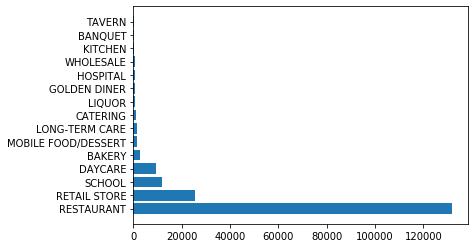

In [426]:
plt.barh(fac_dist.head(15)['Facility Type'],fac_dist.head(15)['Counts'])

### **Number of Facilities in a Type vs. Average Risk Score**

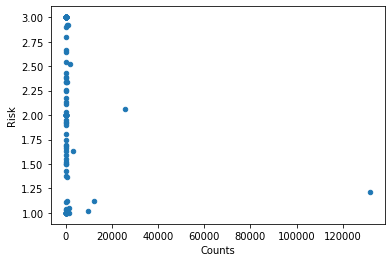

In [427]:
# Perform inner merge on number of facilities and their risk scores 
merged_inner = pd.merge(left=fac_dist,right=grouped_fac_risk_mean,left_on='Facility Type',right_on='Facility Type')
# Scatter plot: number of facilities in each type (i.e. facility type) vs. average risk score
merged_inner.plot.scatter(x='Counts', y='Risk')

We realized that the dataset is unbalanced in terms of number of Facility Types, where there are some Facility Types with very few instances. The types of facilities with very few instances would provide us with little to no information. Hence, we decided to analyze the 50 most frequent type of facilities and drop the others:

In [428]:
print("Number of entries before removing facility types with few instances: " + str(df.size))
df = df[df['Facility Type'].isin(list(fac_dist['Facility Type'])[:50])]
print("Number of entries after removing facility types with few instances: " + str(df.size))

Number of entries before removing facility types with few instances: 3074928
Number of entries after removing facility types with few instances: 3071184


As we can see from the code above, there are around 20 thousand facilities that dont have as much inspections as the others. As a result, data set is more balanced now

### **Out of Business Facilities on Map**

In [429]:
# Out of business facilities
df_oob = df[df.Results.str.contains("Out of Business",na=False)]
df_oob
# Grouped by the facilities
df_oob_unique = df_oob.groupby(['Latitude','Longitude','DBA Name', 'License #']).count()
df_oob_unique.shape

(13287, 12)

We mapped the facilities that have gone out of business to identify any possible pattern:

In [430]:
'''
# Map the facilities that have gone out of business 
map_oob = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

# We take 5000 samples to view on the map
# TODO: take randomized samples / visualize the whole data
marker_cluster = MarkerCluster().add_to(map_oob)
ranges = 0
for i in df_oob_unique.index:
    if ranges == 5000:
        break
    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)        
    ranges = ranges + 1

map_oob
'''

'\n# Map the facilities that have gone out of business \nmap_oob = folium.Map(\n    location=[41.8781, -87.6298],\n    zoom_start=9\n)\n\n# We take 5000 samples to view on the map\n# TODO: take randomized samples / visualize the whole data\nmarker_cluster = MarkerCluster().add_to(map_oob)\nranges = 0\nfor i in df_oob_unique.index:\n    if ranges == 5000:\n        break\n    folium.Marker([(i[0]), (i[1])]).add_to(marker_cluster)        \n    ranges = ranges + 1\n\nmap_oob\n'

### **Average Risk of Facilities on Map**

In [0]:
# Calculate risk mean of each facility
df_avg_risk_score = df.groupby(['Latitude','Longitude','DBA Name'])['Risk'].mean()

We mapped the average risk score of facilities to identify any possible pattern:

In [432]:
# Map the average risk score of facilities, where red indicates high risk, orange indicates medium risk, and green indicates low risk
'''
map_risk = folium.Map(
    location=[41.8781, -87.6298],
    zoom_start=9
)

# We take 2000 samples to view on the map
# TODO: take randomized samples / visualize the whole data
ranges = 0
for i in df_avg_risk_score.index:
    if ranges == 2000:
        break
    if(round(df_avg_risk_score[i]) == 1):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 2):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange')).add_to(map_risk)
    elif(round(df_avg_risk_score[i]) == 3):
        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green')).add_to(map_risk)       
    ranges = ranges + 1

map_risk
'''

"\nmap_risk = folium.Map(\n    location=[41.8781, -87.6298],\n    zoom_start=9\n)\n\n# We take 2000 samples to view on the map\n# TODO: take randomized samples / visualize the whole data\nranges = 0\nfor i in df_avg_risk_score.index:\n    if ranges == 2000:\n        break\n    if(round(df_avg_risk_score[i]) == 1):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='red')).add_to(map_risk)\n    elif(round(df_avg_risk_score[i]) == 2):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='orange')).add_to(map_risk)\n    elif(round(df_avg_risk_score[i]) == 3):\n        folium.Marker([(i[0]), (i[1])],icon=folium.Icon(color='green')).add_to(map_risk)       \n    ranges = ranges + 1\n\nmap_risk\n"

We plotted the number of inspections vs. the average risk score of each facility to identify any possible correlation between the two. We observed the there is a negative correlation between the number of inspections and the average risk of the facility:

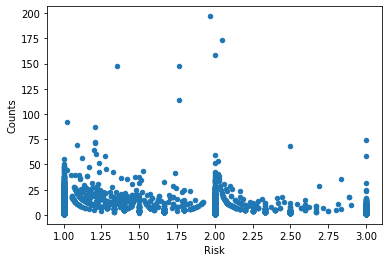

In [433]:
# Scatter plot on the number of inspections vs. the average risk score
df_unique = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count()['Risk']).rename(columns={'Risk':'Counts'})
merged = pd.merge(left=df_avg_risk_score.reset_index(),right=df_unique.reset_index(),left_on=['Latitude','Longitude','DBA Name'],right_on=['Latitude','Longitude','DBA Name'])
merged.plot.scatter(x='Risk', y='Counts')

We observed that the number of risk 3 facilities are lower than the others. Hence, we decided to plot average risk scores vs number of facilities.

### **Correlation between Number of Inspections and Average Level of Risk**

We observed a moderate positive correlation between the number of inspections and average level of risk of the facility (since Risk 1 means high risk and Risk 3 means low risk):

In [434]:
merged[['Risk', 'Counts']].corr(method='pearson')

,Risk,Counts
Risk,1.000000,-0.365569
Counts,-0.365569,1.000000


### **Distribution of Risk Scores of Facilities**

We visualized the distribution of average level of risk scores of each facility using the bar plot below:

In [435]:
# Grouped by risk scores and number of facilities
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score).apply(lambda x: round(x)).reset_index()
df_avg_risk_score1 = pd.DataFrame(df_avg_risk_score1.groupby('Risk').count()['Latitude']).rename(columns={'Latitude':'Counts'})
df_avg_risk_score1

,Counts
Risk,
1.0,15581
2.0,6720
3.0,4688


<BarContainer object of 3 artists>

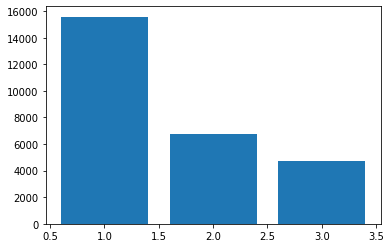

In [436]:
plt.bar(df_avg_risk_score1.index,df_avg_risk_score1['Counts'])

### **Different Branches vs. Risk Score**

For the next milestone, we want to analyze the average risk score of a facility between its different branches.

In [0]:
# Identify the facility with the highest number of branches
#grouped_name = df.groupby('DBA Name').count()
grouped_unique_name = pd.DataFrame(df.groupby('DBA Name').count().rename(columns={'Risk':'Counts'})['Counts']).sort_values(by='Counts',ascending=False).reset_index()
grouped_unique_facility = pd.DataFrame(df.groupby(['Latitude','Longitude','DBA Name']).count().rename(columns={'Risk':'Counts'})['Counts']).sort_values(by='Counts',ascending=False).reset_index()

We will be investigating the facility (chain) with the highest number of branches to see if there is any difference in the risk scores of its branches. 

In [438]:
# The facilities with the highest number of inspections (chain)
grouped_unique_name.head()

,DBA Name,Counts
0,SUBWAY,4069
1,DUNKIN DONUTS,2259
2,MCDONALDS,2216
3,7-ELEVEN,1410
4,STARBUCKS,1398


In [439]:
# The facilities with the highest number of inspections (unique)
grouped_unique_facility.head()

,Latitude,Longitude,DBA Name,Counts
0,41.862628,-87.615031,SPORT SERVICE SOLDIER FIELD,197
1,41.830784,-87.635296,ILLINOIS SPORTSERVICE,173
2,42.008536,-87.914428,STARBUCKS,159
3,42.008536,-87.914428,MCDONALDS,148
4,41.947317,-87.656418,LEVY RESTAURANTS,148


### **Type of Facility vs. Percentage of Going Out of Business**

In [440]:
# Data grouped by the facility type
fac_dist.head()

,Facility Type,Counts
0,RESTAURANT,131852
1,RETAIL STORE,25635
2,SCHOOL,12054
3,DAYCARE,9537
4,BAKERY,2923


In [0]:
# Group out of business facilities on facility type
df_oob_fac = pd.DataFrame(df_oob.groupby('Facility Type').count().rename(columns={'Risk':'Counts'})['Counts'])
merged_fac_oob = pd.merge(left=df_oob_fac.reset_index(), right=fac_dist.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [442]:
merged_fac_oob.head()

,Facility Type,Counts_x,index,Counts_y
0,ASSISTED LIVING/NURSING HOME,4,21,95
1,BAKERY,249,4,2923
2,BANQUET,19,13,338
3,BAR,6,24,81
4,BUTCHER,5,34,34


In [0]:
merged_fac_oob['Oob Ratio'] = merged_fac_oob['Counts_x'].divide(merged_fac_oob['Counts_y'], fill_value=1)

In [444]:
merged_fac_oob.sort_values(by='Oob Ratio', ascending=False).drop(columns='index').head()

,Facility Type,Counts_x,Counts_y,Oob Ratio
30,PANTRY,5,9,0.555556
14,DISTRIBUTION,3,10,0.300000
41,WAREHOUSE,2,13,0.153846
4,BUTCHER,5,34,0.147059
18,HERBAL,6,47,0.127660


In [445]:
merged_fac_oob[['Oob Ratio', 'Counts_y']].corr(method='pearson')

,Oob Ratio,Counts_y
Oob Ratio,1.000000,-0.042375
Counts_y,-0.042375,1.000000


We wanted to identify a possible correlation between the type of facility and the percentage of going out of business. However, when we calculated the pearson's correlation factor, we observed no correlation.

### **Percentage of Going Out of Business vs. Average Risk Score**

In [0]:
# Merge the out of business facility types with their average risk scores
fac_oob_risk = pd.merge(left=merged_fac_oob.reset_index(), right=grouped_fac_risk_mean.reset_index(),left_on=['Facility Type'],right_on=['Facility Type'])

In [447]:
fac_oob_risk.drop(columns=['index_x', 'index_y']).rename(columns={'Counts_x':'Oob Count', 'Counts_y':'Total Count'}).head()

,level_0,Facility Type,Oob Count,Total Count,Oob Ratio,Risk
0,0,ASSISTED LIVING/NURSING HOME,4,95,0.042105,1.000000
1,1,BAKERY,249,2923,0.085186,1.629490
2,2,BANQUET,19,338,0.056213,1.118343
3,3,BAR,6,81,0.074074,2.135802
4,4,BUTCHER,5,34,0.147059,2.029412


In [448]:
fac_oob_risk[['Oob Ratio', 'Risk']].corr(method='pearson')

,Oob Ratio,Risk
Oob Ratio,1.000000,0.202511
Risk,0.202511,1.000000


We wanted to identify a possible correlation between the out of business ratio and the risk of the type of facility. However, when we calculated the pearson's correlation factor, we observed no correlation.



## **Violation Type Analysis**

### **Violations analysis - facilities that have gone out of business**

In [449]:
df_oob_unique.reset_index(inplace=True)
merged_oob = pd.merge(left=df_oob_unique[['Latitude', 'Longitude', 'DBA Name']], right=df, on=['Latitude', 'Longitude', 'DBA Name'])
merged_oob.head(10)

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.64467,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: NO CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT MANAGERS MUST HAVE A VALID CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE WHILE ON DUTY AT ALL TIMES. PRIORITY FOUNDATION VIOLATION 7-38-012 ISSUED. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: : 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) CITATION ISSUED. VIOLATION PREVIOUSLY ISSUED ON AUGUST 14, 2018. | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005 CITATION ISSUED. VIOLATION WAS PREVIOUSLY ISSUED ON AUGUST 14, 2018.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
1,41.64467,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: 2-102.12 NO VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATES ON PREMISES. THE PIC ON DUTY WAS UNABLE TO PRODUCE A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. NO OTHER PERSONS WERE ON DUTY THAT HAD A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. INSTRUCTED THAT A VALID CERTIFICATE MUST BE ON PREMISES AT ALL TIMES. PRIORITY FOUNDATION VIOLATION ISSUED 7-38-012. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS RE1QUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: 4-602.13 OBSERVED THE EXTERIOR SURFACES AND INTERIOR BOTTOM OF THE DEEP FRYERS IN NEED OF CLEANING TO REMOVE GREASE; CLEAN AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: 6-501.12 THE FLOORS UNDER AROUND AND BEHIND VARIOUS KITCHEN EQUIPMENT NEED CLEANING; ALSO FLOOR DRAINS THROUGHOUT THE KITCHEN NEED CLEANING; CLEAN AND MAINTAIN FLOORS AND FLOOR DRAINS.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
2,41.64467,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: FLOORS NEED CLEANING IN THE REAR STORAGE AREA ALONG THE WALL BASE UNDER STORAGE SHELVING AND IN THE PREP AREA AROUND THE COOKING EQUIPMENT TO REMOVE SPILLS,GREASE AND DEBRIS. ALSO CLEAN THE MATS IN THE WALK IN COOLER AND FREEZER TO REMOVE SPILLS. | 35. WALLS, CEILINGS, AT

In [450]:
# Out of business facilities that have more than 1 inspection
dup_oob = merged_oob.groupby(['Latitude', 'Longitude', 'DBA Name']).filter(lambda x : len(x) > 1)
dup_oob.head(10)

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.64467,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: NO CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT MANAGERS MUST HAVE A VALID CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE WHILE ON DUTY AT ALL TIMES. PRIORITY FOUNDATION VIOLATION 7-38-012 ISSUED. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: : 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) CITATION ISSUED. VIOLATION PREVIOUSLY ISSUED ON AUGUST 14, 2018. | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005 CITATION ISSUED. VIOLATION WAS PREVIOUSLY ISSUED ON AUGUST 14, 2018.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
1,41.64467,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: 2-102.12 NO VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATES ON PREMISES. THE PIC ON DUTY WAS UNABLE TO PRODUCE A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. NO OTHER PERSONS WERE ON DUTY THAT HAD A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. INSTRUCTED THAT A VALID CERTIFICATE MUST BE ON PREMISES AT ALL TIMES. PRIORITY FOUNDATION VIOLATION ISSUED 7-38-012. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS RE1QUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: 4-602.13 OBSERVED THE EXTERIOR SURFACES AND INTERIOR BOTTOM OF THE DEEP FRYERS IN NEED OF CLEANING TO REMOVE GREASE; CLEAN AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: 6-501.12 THE FLOORS UNDER AROUND AND BEHIND VARIOUS KITCHEN EQUIPMENT NEED CLEANING; ALSO FLOOR DRAINS THROUGHOUT THE KITCHEN NEED CLEANING; CLEAN AND MAINTAIN FLOORS AND FLOOR DRAINS.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
2,41.64467,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: FLOORS NEED CLEANING IN THE REAR STORAGE AREA ALONG THE WALL BASE UNDER STORAGE SHELVING AND IN THE PREP AREA AROUND THE COOKING EQUIPMENT TO REMOVE SPILLS,GREASE AND DEBRIS. ALSO CLEAN THE MATS IN THE WALK IN COOLER AND FREEZER TO REMOVE SPILLS. | 35. WALLS, CEILINGS, AT

In [451]:
dup_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
dup_oob.head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.644670,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: NO CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT MANAGERS MUST HAVE A VALID CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE WHILE ON DUTY AT ALL TIMES. PRIORITY FOUNDATION VIOLATION 7-38-012 ISSUED. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: : 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) CITATION ISSUED. VIOLATION PREVIOUSLY ISSUED ON AUGUST 14, 2018. | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005 CITATION ISSUED. VIOLATION WAS PREVIOUSLY ISSUED ON AUGUST 14, 2018.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
1,41.644670,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: 2-102.12 NO VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATES ON PREMISES. THE PIC ON DUTY WAS UNABLE TO PRODUCE A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. NO OTHER PERSONS WERE ON DUTY THAT HAD A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. INSTRUCTED THAT A VALID CERTIFICATE MUST BE ON PREMISES AT ALL TIMES. PRIORITY FOUNDATION VIOLATION ISSUED 7-38-012. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS RE1QUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: 4-602.13 OBSERVED THE EXTERIOR SURFACES AND INTERIOR BOTTOM OF THE DEEP FRYERS IN NEED OF CLEANING TO REMOVE GREASE; CLEAN AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: 6-501.12 THE FLOORS UNDER AROUND AND BEHIND VARIOUS KITCHEN EQUIPMENT NEED CLEANING; ALSO FLOOR DRAINS THROUGHOUT THE KITCHEN NEED CLEANING; CLEAN AND MAINTAIN FLOORS AND FLOOR DRAINS.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
2,41.644670,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: FLOORS NEED CLEANING IN THE REAR STORAGE AREA ALONG THE WALL BASE UNDER STORAGE SHELVING AND IN THE PREP AREA AROUND THE COOKING EQUIPMENT TO REMOVE SPILLS,GREASE AND DEBRIS. ALSO CLEAN THE MATS IN THE WALK IN COOLER AND FREEZER TO REMOVE SPILLS. | 35. WALLS, CEILINGS,

In [452]:
violations_oob = dup_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_oob = pd.DataFrame(violations_oob)
violation_nums_oob = violations_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
violation_nums_oob

0         [2, 3, 5]               
1         [2, 3, 5, 49, 55]       
2         [34, 35, 38]            
3         [33, 34, 45]            
6         [12, 21, 28, 29, 33, 38]
                    ...           
100332    [32, 33, 34]            
100333    [41]                    
100334    [18, 28, 41]            
100335    [21, 33]                
100336    [18, 21, 33]            
Name: Violations, Length: 65918, dtype: object

In [453]:
violation_nums_oob = pd.DataFrame(violation_nums_oob)
violation_nums_oob.reset_index(inplace=True)
violation_nums_oob.drop(columns='index', inplace=True)
violation_nums_oob.head(10)

,Violations
0,"[2, 3, 5]"
1,"[2, 3, 5, 49, 55]"
2,"[34, 35, 38]"
3,"[33, 34, 45]"
4,"[12, 21, 28, 29, 33, 38]"
5,"[21, 33, 34, 35, 38, 40, 41, 42]"
6,"[8, 21, 33, 34, 35, 36, 38]"
7,"[33, 34, 35, 36, 38]"
8,"[3, 12, 21, 33, 34]"
9,"[33, 34, 35]"


In [0]:
vio_freq_oob = {}
for i in violation_nums_oob['Violations']:
  for j in i:
    vio_freq_oob[str(j)] = 1 if str(j) not in vio_freq_oob else vio_freq_oob[str(j)]+1

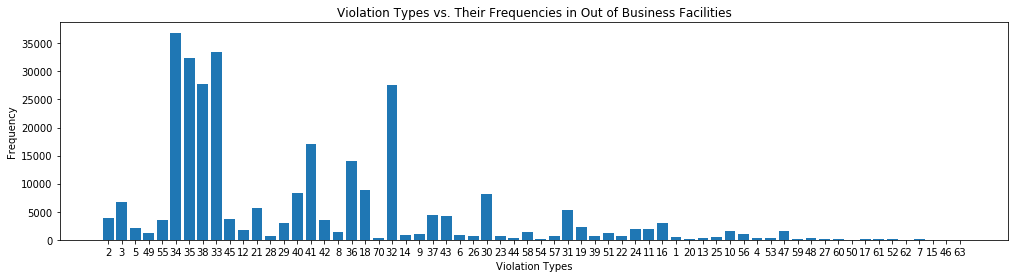

In [455]:
plt.figure(figsize=(17,4))
plt.bar(list(vio_freq_oob.keys()), vio_freq_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

From the figure above, we can see that certain violation types outnumber the others. So, we decided to sort the violation types in terms of their frequencies and display them in the graph below.

In [0]:
sorted_vio_freq_oob = {}

for key in sorted(vio_freq_oob, key=vio_freq_oob.__getitem__, reverse=True):
  sorted_vio_freq_oob[key] = vio_freq_oob[key]

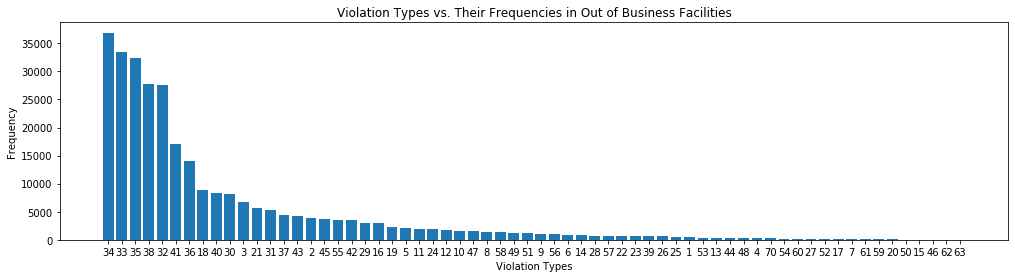

In [457]:
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_oob.keys()), sorted_vio_freq_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [458]:
most_freq_vio_oob = [key for key, value in list(sorted_vio_freq_oob.items())[0:15]]
most_freq_vio_oob # top 10 most frequent violation types among facilities that went out of business

['34',
 '33',
 '35',
 '38',
 '32',
 '41',
 '36',
 '18',
 '40',
 '30',
 '3',
 '21',
 '31',
 '37',
 '43']

In [0]:
# Inspections of facilities that didn't go out of business
# https://stackoverflow.com/questions/18180763/set-difference-for-pandas
 set_diff_oob = pd.concat([df, merged_oob, merged_oob], sort=True).drop_duplicates(keep=False, subset=['Latitude', 'Longitude', 'DBA Name', 'Inspection Date'])

In [460]:
set_diff_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (not out of business facilities)
set_diff_oob.head(10)

,AKA Name,Address,DBA Name,Facility Type,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Regions,Results,Risk,Violations,Zip
1,CHILI'S (T1-B14),11601 W TOUHY AVE,CHILIS T-I,RESTAURANT,2019-12-04T00:00:00.000,2352734,CANVASS,42.008536,34169.0,"{'latitude': '-87.91442843927047', 'longitude': '42.008536400868735'}",-87.914428,O'Hare,Pass,1,"10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLIED AND ACCESSIBLE - Comments: OBSERVED NO HAND WASHING SIGNAGE FOR HAND SINK AT REAR DISH WASHING AREA.MUST PROVIDE AND MAINTAIN. | 47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE, PROPERLY DESIGNED, CONSTRUCTED & USED - Comments: OBSERVED A TORN DOOR GASKET INSIDE OF THE 2 DOOR PREP COOLER SHOWED MANAGER. MUST REPLACE THE TORN DOOR GASKET AND TO MAINTAIN. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: INSTRUCTED TO DETAIL CLEAN AND MAINTAIN THE INTERIORS OF PREP COOLERS IN THE FOOD PREP AREA AND THE SIDES OF HOT COOKING EQUIPMENTS. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: INSTRUCTED TO REMOVE DUSTS AND FOOD SPLASHED DEBRIS ON WALLS AND CEILINGS AND ATTACHED CEILING VENTILATION COVERS IN FOOD PREP AREA AND REAR DISH WASHING AREA SHOWED MANAGER AND TO MAINTAIN. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: OBSERVED DIRTY FLOORS UNDER AND AROUND THE ICE MACHINE SHOWED MANAGER,CLEAN FLOORS IN DETAIL AND TO MAINTAIN.",60666.0
2,NaN,3401 W BELMONT AVE,TAQUERIA BLUE LINE,RESTAURANT,2019-12-04T00:00:00.000,2352701,LICENSE,41.939168,2703436.0,"{'latitude': '-87.71254599117191', 'longitude': '41.93916783376966'}",-87.712546,Avondale,Pass w/ Conditions,1,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: NO EMPLOYEE HEALTH POLICY ON PREMISES. INSTRUCTED MANAGER MUST PROVIDE AN EMPLOYEE HEALTH POLICY ON PREMISES. PRIORITY FOUNDATION 7-38-010. NO CITATION ISSUED. | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: NO VOMIT AND DIARRHEA CLEANING PROCEDURE ON PREMISES. INSTRUCTED MANAGER MUST PROVIDE A VOMIT AND DIARRHEA CLEANING PROCEDURE WITH ALL NECESSARY ITEMS AS OUTLINED IN POLICY ON PREMISES. PRIORITY FOUNDATION 7-38-005. NO CITATION ISSUED. | 16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED - Comments: OBSERVED SLIGHT CALCIUM BUILD UP INSIDE ICE MACHINE. MUST CLEAN INTERIOR OF ICE MACHINE AND MAINTAIN. | 51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES - Comments: OBSERVED 3-COMPARTMENT SINK STOPPERS (X2) NOT WORKING. MUST PROVIDE ADDITIONAL WORKING STOPPERS (X2) FOR 3-COMPARTMENT SINK. | 53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: NO COVERED TRASH RECEPTACLE IN WASHROOM. MUST PROVIDE. | 58. ALLERGEN TRAINING AS REQUIRED - Comments: NO FOOD ALLERGEN TRAINING CERTIFICATE ON PREMISES. INSTRUCTED ALL CITY OF CHICAGO CERTIFIED FOOD MANAGERS MUST HAVE FOOD ALLERGEN TRAINING CERTIFICATES ON PREMISES.",60618.0
6,NAIBOA LATIN STORE,3349 N CLARK ST,NAIBOA LATIN STORE,RETAIL STORE,2019-12-04T00:00:00.000,2352702,LICENSE,41.943032,2698776.0,"{'latitude': '-87.65299525711882', 'longitude': '41.943031768727145'}",-87.652995,Lake View,Pass w/ Conditions,3,"5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: MANAGEMENT UNABLE TO PROVIDE A PROCEDURE FOR CLEANING UP VOMITING AND DIARRHEA.INSTRUCTED TO HAVE ONE INCLUDING THE CHEMICALS AND SUPPLIES NEEDED. PRIORITY FOUNDATION #7-38-005. NO CITATION ISSUED | 36. THERMOMETERS PROVIDED & ACCURATE - Comments: NOTED NO THERMOMETERS INSIDE REFRIGERATION UNIT CONSPICUOUSLY POSTED TO MONITOR THE AMBIENT TEMPERATURE OF EQUIPMENT. INSTRUCTED TO EQUIP ALL REFRIGERATION UNITS WITH ACCURATE AND WORKING THERMOMETERS. | 51. PLUMBING INSTALLED; PROPER BACKFLOW DEVICES - Comments: NOTED NO MOP SINK ON PREMISE. INSTRUCTED TO INSTALL A MOP SINK WITH A BACK FLOW PREVENTION DEVICE. | 53. TOILET FACILITIES: PROPERLY CONSTRUCTED, SUPPLIED, & CLEANED - Comments: NOTED WASH ROOMS ON PREMISE WITH GARBAGE RECEPTACLES AND NO LID

### **Violations analysis - facilities that have not gone out of business**

In [461]:
violations_not_oob = set_diff_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
violations_not_oob = pd.DataFrame(violations_not_oob)
violation_nums_not_oob = violations_not_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
violation_nums_not_oob

1         [10, 47, 49, 55, 55]                        
2         [3, 5, 16, 51, 53, 58]                      
6         [5, 36, 51, 53]                             
7         [49, 55, 56]                                
9         [25]                                        
          ...                                         
192162    [38]                                        
192171    [12, 21, 33, 34, 35, 38, 41]                
192173    [32, 33, 35, 38, 40]                        
192174    [33, 34, 35, 38, 41]                        
192180    [18, 19, 32, 33, 34, 35, 36, 37, 38, 39, 41]
Name: Violations, Length: 85369, dtype: object

In [462]:
violation_nums_not_oob = pd.DataFrame(violation_nums_not_oob)
violation_nums_not_oob.reset_index(inplace=True)
violation_nums_not_oob.drop(columns='index', inplace=True)
violation_nums_not_oob.head(10)

,Violations
0,"[10, 47, 49, 55, 55]"
1,"[3, 5, 16, 51, 53, 58]"
2,"[5, 36, 51, 53]"
3,"[49, 55, 56]"
4,[25]
5,"[3, 5, 10, 49, 51, 53, 55, 55]"
6,"[45, 55]"
7,"[3, 5, 57]"
8,"[10, 10, 10, 23, 25, 39, 50, 52, 55, 55, 56]"
9,"[49, 55, 55, 56, 57]"


In [0]:
vio_freq_not_oob = {}
for i in violation_nums_not_oob['Violations']:
  for j in i:
    vio_freq_not_oob[str(j)] = 1 if str(j) not in vio_freq_not_oob else vio_freq_not_oob[str(j)]+1

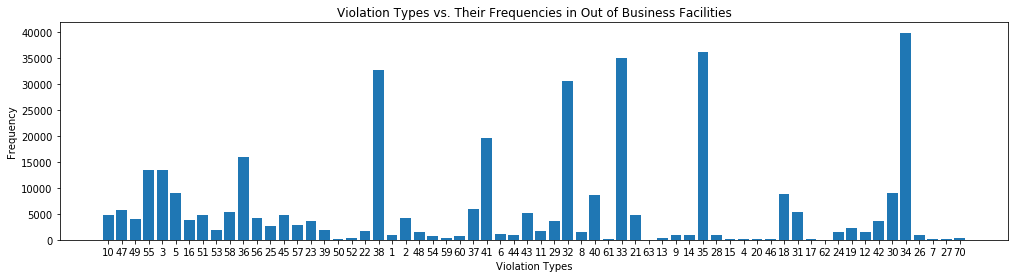

In [464]:
plt.figure(figsize=(17,4))
plt.bar(list(vio_freq_not_oob.keys()), vio_freq_not_oob.values())
plt.title('Violation Types vs. Their Frequencies in Out of Business Facilities')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [0]:
sorted_vio_freq_not_oob = {}

for key in sorted(vio_freq_not_oob, key=vio_freq_not_oob.__getitem__, reverse=True):
  sorted_vio_freq_not_oob[key] = vio_freq_not_oob[key]

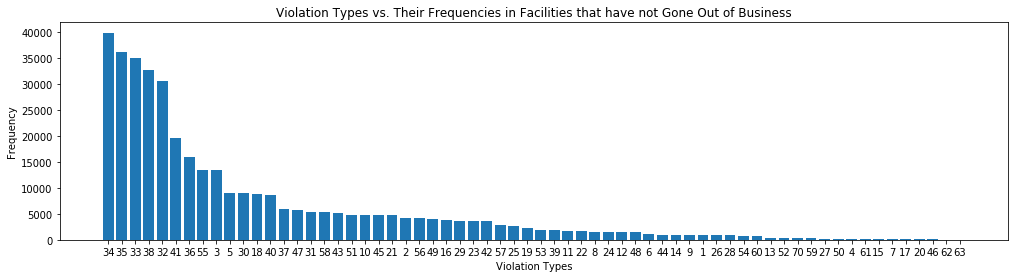

In [466]:
plt.figure(figsize=(17,4))
plt.bar(list(sorted_vio_freq_not_oob.keys()), sorted_vio_freq_not_oob.values())
plt.title('Violation Types vs. Their Frequencies in Facilities that have not Gone Out of Business')
plt.xlabel('Violation Types')
plt.ylabel('Frequency')
plt.show()

In [467]:
most_freq_vio_not_oob = [key for key, value in list(sorted_vio_freq_not_oob.items())[0:15]]
most_freq_vio_not_oob # top 10 most frequent violation types among facilities that went out of business

['34',
 '35',
 '33',
 '38',
 '32',
 '41',
 '36',
 '55',
 '3',
 '5',
 '30',
 '18',
 '40',
 '37',
 '47']

In [0]:
# TODO: remove set_diff_not_oob and replace by merged_oob in other fragments of the code
# Inspections of facilities that didn't go out of business
 set_diff_not_oob = merged_oob
 #pd.concat([df, set_diff_oob, set_diff_oob], sort=True).drop_duplicates(keep=False, subset=['Latitude', 'Longitude', 'DBA Name', 'License #', 'Inspection Date'])

In [500]:
set_diff_not_oob.dropna(subset=['Violations'], inplace=True) # the inspections that have violations (out of business facilities)
set_diff_not_oob.sort_values(by='AKA Name').head(10)

,AKA Name,Address,DBA Name,Facility Type,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Regions,Results,Risk,Violations,Zip
176207,"#1 CHINA EXPRESS , LTD",4248 S WENTWORTH AVE,#1 CHINA EXPRESS,RESTAURANT,2010-11-29T00:00:00.000,467259,CANVASS,41.816834,1869616.0,"{'latitude': '-87.6313462733625', 'longitude': '41.816833769262814'}",-87.631346,Fuller Park,Pass,1,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABELED: CUSTOMER ADVISORY POSTED AS NEEDED - Comments: ALL BULK FOOD STORAGE CONTAINERS MUST BE PROPERLY LABELED. PLASTIC GROCERY BAGS SHOULD NOT BE USED TO STORE UNCOVERED FOODS. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: CLEAN THE FOLLOWING: INTERIOR CABINETS OF BOTH DEEP FRYERS, SIDES & EXTERIORS OF ALL COOKING EQUIPMENT, INTERIORS OF BOTH WALK-IN COOLER & FREEZER, ALL STORAGE SHELVES & RACKS, EXTERIORS OF ALL LARGE BULK FOOD STORAGE CONTAINERS, INTERIOR & EXTERIOR OF BAR B Q COOKER AND ALL OTHER UNCLEAN SURFACES THROUGHOUT. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: DETAIL CLEAN ALL FLOORS ALONG ALL WALL BASES, IN CORNERS, UNDERNEATH & BEHIND ALL HEAVY EQUIPMENT. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: CLEAN ALL WALLS THROUGHOUT ALL AREAS OF BUSINESS (INCLUDING REAR DOORWAY FRAME). CLEAN LIGHT SHIELDS, CEILING TILES AND VENTS WHERE NEEDED. | 41. PREMISES MAINTAINED FREE OF LITTER, UNNECESSARY ARTICLES, CLEANING EQUIPMENT PROPERLY STORED - Comments: MOP SINK MUST BE CLEARLY ACCESSIBLE FOR USE. | 42. APPROPRIATE METHOD OF HANDLING OF FOOD (ICE) HAIR RESTRAINTS AND CLEAN APPAREL WORN - Comments: ALL FOOD HANDLERS MUST WEAR HAIR RESTRAINTS",60609.0
96043,#1 CHOP SUEY,1907 W 87TH ST,#1 CHOP SUEY,RESTAURANT,2015-02-04T00:00:00.000,1480501,COMPLAINT,41.735578,2042372.0,"{'latitude': '-87.67078075079954', 'longitude': '41.735578274725285'}",-87.670781,Auburn Gresham,Pass w/ Conditions,1,"11. ADEQUATE NUMBER, CONVENIENT, ACCESSIBLE, DESIGNED, AND MAINTAINED - Comments: EXPOSED HANDSINK NOT ACCESSIBLE, LARGE LADDER IN FRONT OF SINK, EMPLOYEES UNABLE TO ACCESS SINK. INSTD TO HAVE CLEAR AND ACCESSIBLE AT ALL TIMES. CITATION ISSUED 7-38-030 CRITICAL. | 32. FOOD AND NON-FOOD CONTACT SURFACES PROPERLY DESIGNED, CONSTRUCTED AND MAINTAINED - Comments: ALL CUTTING BOARDS ON PREMISES STAINED WITH DEEP, DARK GROOVES. INSTD TO REPLACE ALL CUTTING BOARDS AND MAINTAIN. INTERIOR LIDS OF RICE COOKER WITH RUST ACCUMULATION. REPLACE SAME AND MAINTAIN FREE OF RUST. | 33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSILS CLEAN, FREE OF ABRASIVE DETERGENTS - Comments: THE FOLLOWING FOOD AND NON-FOOD EQUIPMENT THRU-OUT NOT CLEAN, EXCESSIVE FOOD DEBRIS ACCUMULATION, DUST, AND GREASE NOTED: INTERIOR/EXTERIOR OF WOK STATION, INTERIOR/EXTERIOR OF STOVE, EXTERIOR SIDES, AND INTERIOR BOTTOM OF FRYERS, INTERIOR/EXTERIOR OF ALL COOLERS, INCLUDING DOORS , DOOR HANDLES, AND RUBBER GASKETS OF DOORS, EXTERIOR OF TRASH CONTAINERS, STORAGE SHELVES, STEAM TABLE, MICROWAVE, AND ALL SINKS. INSTD TO CLEAN SAME, FREE OF ALL BUILD-UP AND MAINTAIN. | 34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: FLOOR THRU-OUT UNDER, BEHIND HEAVY EQUIPMENT AND ALONG WALLBASE NOT CLEAN, EXCESSIVE ACCUMULATION. INSTD TO CLEAN AND MAINTAIN SAME. | 35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTRUCTED PER CODE: GOOD REPAIR, SURFACES CLEAN AND DUST-LESS CLEANING METHODS - Comments: CEILING THRU-OUT WITH DUST ACCUMULATION. INSDT TO CLEAN AND MAINTAIN SAME FREE OF DUST/DEBRIS. ALL WALLS, DOORS, LIGHTSWITCH COVERS THRU-OUT NOT CLEAN AND WITH WORN SURFACES. INSTD TO CLEAN AND MAINTAIN. INSTD TO PAINT IF NECESSARY AFTER CLEANING. | 42. APPROPRIATE METHOD OF HANDLING OF FOOD (ICE) HAIR RESTRAINTS AND CLEAN APPAREL WORN - Comments: FOOH HANDLER WEARING UNCLEAN APRON. INSTD TO WEA

Our aim was to detect any violation type that could result into the facilities going out of business. From our data analysis, we found that most violation types are common between those that went out of business and those that have not. Only Violation Types 21, 31, and 43 are more prevalent in facilities that have gone out of business, but are not so prevalent in those that have not gone out of business.

### **Distribution of number of violations committed in each inspection (in facilities that went out of business)**

In [0]:
num_vio_oob = []
for i in violation_nums_oob['Violations']:
  num_vio_oob.append(len(i))

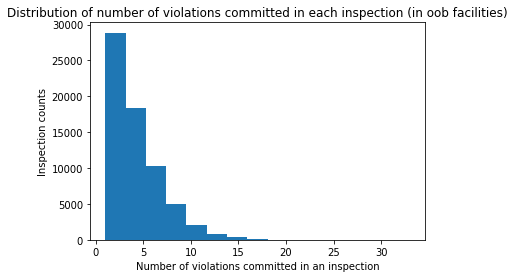

In [471]:
plt.hist(num_vio_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in oob facilities)')
plt.xlabel('Number of violations committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

In [472]:
print('Average number of violations committed in each inspection (OOB): ' + str(np.mean(num_vio_oob)))
print('Median number of violations committed in each inspection (OOB): ' + str(np.median(num_vio_oob)))

Average number of violations committed in each inspection (OOB): 4.428259352528899
Median number of violations committed in each inspection (OOB): 4.0


### **Distribution of number of violations committed in each inspection (in facilities that did NOT go out of business)**

In [0]:
num_vio_not_oob = []
for i in violation_nums_not_oob['Violations']:
  num_vio_not_oob.append(len(i))

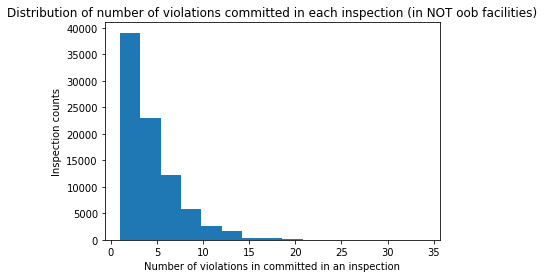

In [474]:
plt.hist(num_vio_not_oob, bins=15)
plt.title('Distribution of number of violations committed in each inspection (in NOT oob facilities)')
plt.xlabel('Number of violations in committed in an inspection')
plt.ylabel('Inspection counts')
plt.show()

In [475]:
print('Average number of violations committed in each inspection (not OOB): ' + str(np.mean(num_vio_not_oob)))
print('Median number of violations committed in each inspection (not OOB): ' + str(np.median(num_vio_not_oob)))

Average number of violations committed in each inspection (not OOB): 4.416111234757348
Median number of violations committed in each inspection (not OOB): 4.0


We observe that the average number of violations committed in each inspection in facilities that went out of business is slightly higher than those that have not gone out of business. 

### **Distribution of total number of violations facilities commit before going out of business**

In [476]:
dup_oob['Violations'].update(violation_nums_oob['Violations'])
dup_oob['Number of Violations'] = dup_oob.Violations.apply(lambda x: len(x)) # create num of violations column
dup_oob.head(10)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions,Number of Violations
0,41.644670,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[2, 3, 5]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,3
1,41.644670,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[2, 3, 5, 49, 55]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,5
2,41.644670,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"[34, 35, 38]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,3
3,41.644670,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,"[33, 34, 45]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,3
6,41.644670,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,"[8, 21, 33, 34, 35, 36, 38]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,7
7,41.644670,-87.540095,BURGER KING,1300984,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-12-19T00:00:00.000,CANVASS,Pass w/ Conditions,"[33, 34, 35, 36, 38]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,5
8,41.644670,-87.540095,BURGER KING,537818,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2012-01-10T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[3, 12, 21, 33, 34]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,5
9,41.644670,-87.540095,BURGER KING,537384,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2011-05-26T00:00:00.000,COMPLAINT,Pass,"[33, 34, 35]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,3
10,41.644670,-87.540095,BURGER KING,419402,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2010-10-12T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[18, 33, 34, 35, 38, 70]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch,6
14,41.646371,-87.560342,WINJAMMER MARINA,1395212,WINJAMMER MARINA,79113.0,RESTAURANT,2,13701 S HOXIE AVE,60633.0,2013-12-30T00:00:00.000,CANVASS,Pass,"[14, 18, 34, 35, 36]","{'latitude': '-87.56034196262158', 'longitude': '41.64637082018021'}",Hegewisch,5


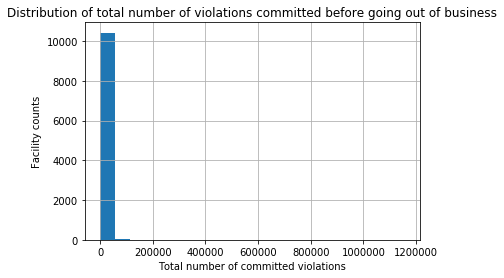

In [477]:
sum_vios = dup_oob.groupby(['DBA Name', 'Latitude', 'Longitude'])['Number of Violations'].sum()
sum_vios.hist(bins=20)
plt.title('Distribution of total number of violations committed before going out of business')
plt.xlabel('Total number of committed violations')
plt.ylabel('Facility counts')
plt.show()

### **Average risk of oob facilities vs. Average risk of NOT oob facilities**

In [478]:
merged_oob['Risk'].mean()

1.3819627854131578

In [479]:
set_diff_not_oob['Risk'].mean() 

1.3027243617784465

In [480]:
set_diff_oob['Risk'].mean()  

1.2918272440815752

### **Region vs. Risk Score**

In [481]:
df_region = df.groupby('Regions')['Risk'].mean()
df_region.to_frame().nsmallest(10, 'Risk')

,Risk
Regions,
Burnside,1.000000
Greektown,1.118868
Chinatown,1.140767
Oakland,1.166667
Grant Park,1.176471
Gold Coast,1.203150
Norwood Park,1.203680
Edison Park,1.206951
River North,1.209792


In [482]:
df_region.to_frame().nlargest(10, 'Risk')

,Risk
Regions,
Garfield Park,1.676331
Englewood,1.635163
Grand Crossing,1.602637
Woodlawn,1.601351
Austin,1.589451
Museum Campus,1.586124
North Lawndale,1.581455
Auburn Gresham,1.573504
United Center,1.567227


In [0]:
# TODO: combine this with the percentage(?) of OOB, average # violations, and then rank
# TODO: run knn (or any unsupervised classification) algorithm to cluster neighborhoods, see if it clustered into meaningful clusters

In [0]:
df_region_fac = df.groupby(['Regions', 'Facility Type'])['Risk'].mean()

### **Violation Type Numbers and Their Description**

Violations numbered 1-44 and 70.

Violation #1-14: critical

Violation #15-29: serious 

In [485]:
df_nan_removed_vio = df.dropna(subset=['Violations'])
dict_vio = {}

for j in df_nan_removed_vio['Violations']:
  vio_list = j.split(" | ")
  for i in vio_list:
    result = i[i.find("[0-9]+[. ]")+1 : i.find(" - Comments")]
    vio_pair = result.split(".")
    if(vio_pair[0] not in dict_vio):
      dict_vio[vio_pair[0]] = vio_pair[1]

print(len(dict_vio)) 

dict_vio_sorted = {int(k):v for k,v in dict_vio.items()}
print(sorted(dict_vio_sorted))

#pd.set_option('display.max_colwidth', -1)

vio_descr = pd.DataFrame(list(dict_vio_sorted.items())).rename(columns={0:'Violation Number', 1:'Description'}).sort_values(by=['Violation Number']).set_index('Violation Number')
vio_descr.head(50)

64
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 70]


,Description
Violation Number,
1,"PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES"
2,CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE
3,"MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING"
4,PROPER USE OF RESTRICTION AND EXCLUSIO
5,PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS
6,"PROPER EATING, TASTING, DRINKING, OR TOBACCO USE"
7,"NO DISCHARGE FROM EYES, NOSE, AND MOUT"
8,HANDS CLEAN & PROPERLY WASHED
9,NO BARE HAND CONTACT WITH RTE FOOD OR A PRE-APPROVED ALTERNATIVE PROCEDURE PROPERLY ALLOWED


In [486]:
merged_oob # facilities that have gone oob
set_diff_oob # facilities that haven't gone oob
critical_vios = list(range(15))
serious_vios = list(range(15, 30))
merged_oob.head()

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.64467,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: NO CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT MANAGERS MUST HAVE A VALID CITY OF CHICAGO FOOD SERVICE MANAGERS CERTIFICATE WHILE ON DUTY AT ALL TIMES. PRIORITY FOUNDATION VIOLATION 7-38-012 ISSUED. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: : 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) CITATION ISSUED. VIOLATION PREVIOUSLY ISSUED ON AUGUST 14, 2018. | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005 CITATION ISSUED. VIOLATION WAS PREVIOUSLY ISSUED ON AUGUST 14, 2018.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
1,41.64467,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"2. CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE - Comments: 2-102.12 NO VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATES ON PREMISES. THE PIC ON DUTY WAS UNABLE TO PRODUCE A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. NO OTHER PERSONS WERE ON DUTY THAT HAD A VALID CITY OF CHICAGO FOOD SERVICE SANITATION CERTIFICATE. INSTRUCTED THAT A VALID CERTIFICATE MUST BE ON PREMISES AT ALL TIMES. PRIORITY FOUNDATION VIOLATION ISSUED 7-38-012. | 3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL EMPLOYEE; KNOWLEDGE, RESPONSIBILITIES AND REPORTING - Comments: 2-102.14(A) NO EMPLOYEE HEALTH POLICY ON PREMISES AS RE1QUIRED; MUST PROVIDE. INSTRUCTED THE PIC TO PROVIDE DOCUMENTATION OF EMPLOYEES RESPONSIBILITY TO REPORT ANY ILLNESS TRANSMISSIBLE THROUGH FOOD. PRIORITY FOUNDATION 7-38-012(A) | 5. PROCEDURES FOR RESPONDING TO VOMITING AND DIARRHEAL EVENTS - Comments: 2-501.11 NO VOMIT AND DIARRHEAL CLEAN UP PROCEDURE ON PREMISES AS REQUIRED; MUST PROVIDE. INSTRUCTED THE PIC THAT A VOMIT AND DIARRHEAL CLEAN UP PROCEDURE MUST BE DOCUMENTED AND THE NECESSARY SUPPLIES ON HAND IN THE EVENT OF A VOMIT OR DIARRHEAL INCIDENT ON PREMISES. PRIORITY FOUNDATION VIOLATION 7-38-005. | 49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Comments: 4-602.13 OBSERVED THE EXTERIOR SURFACES AND INTERIOR BOTTOM OF THE DEEP FRYERS IN NEED OF CLEANING TO REMOVE GREASE; CLEAN AND MAINTAIN. | 55. PHYSICAL FACILITIES INSTALLED, MAINTAINED & CLEAN - Comments: 6-501.12 THE FLOORS UNDER AROUND AND BEHIND VARIOUS KITCHEN EQUIPMENT NEED CLEANING; ALSO FLOOR DRAINS THROUGHOUT THE KITCHEN NEED CLEANING; CLEAN AND MAINTAIN FLOORS AND FLOOR DRAINS.","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
2,41.64467,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOOD REPAIR, COVING INSTALLED, DUST-LESS CLEANING METHODS USED - Comments: FLOORS NEED CLEANING IN THE REAR STORAGE AREA ALONG THE WALL BASE UNDER STORAGE SHELVING AND IN THE PREP AREA AROUND THE COOKING EQUIPMENT TO REMOVE SPILLS,GREASE AND DEBRIS. ALSO CLEAN THE MATS IN THE WALK IN COOLER AND FREEZER TO REMOVE SPILLS. | 35. WALLS, CEILINGS, AT

In [487]:
merged_oob.dropna(subset=['Violations'], inplace=True)
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])

merged_oob

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.644670,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[2, 3, 5]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
1,41.644670,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[2, 3, 5, 49, 55]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
2,41.644670,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"[34, 35, 38]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
3,41.644670,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,"[33, 34, 45]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
6,41.644670,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,"[12, 21, 28, 29, 33, 38]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100332,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,1326791,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,SCHOOL,1,7647 N PAULINA ST,60626.0,2013-04-08T00:00:00.000,CANVASS,Pass,"[32, 33, 34]","{'latitude': '-87.67293385361205', 'longitude': '42.0207528932753'}",Rogers Park
100333,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,1285809,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,SCHOOL,1,7647 N PAULINA ST,60626.0,2012-10-11T00:00:00.000,CANVASS,Pass,[41],"{'latitude': '-87.67293385361205', 'longitude': '42.0207528932753'}",Rogers Park
100334,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,1106356,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,SCHOOL,1,7647 N PAULINA ST,60626.0,2012-10-04T00:00:00.000,CANVASS,Fail,"[18, 28, 41]","{'latitude': '-87.67293385361205', 'longitude': '42.0207528932753'}",Rogers Park
100335,42.020753,-87.672934,HOWARD AREA ALTERNATIVE HIGH SCHOOL,1214975,HOWARD AREA ALTERNATIVE HIGH SCHOOL,2510907.0,SCHOOL,1,7647 N PAULINA ST,60626.0,2012-05-17T00:00:00.000,CANVASS,Pass w/ Conditions,"[21, 33]","{'latitude': '-87.67293385361205', 'longitude': '42.0207528932753'}",Rogers Park


In [0]:
merged_oob['Violations'] = merged_oob['Violations'].apply(lambda x: [x for x in x if x not in critical_vios + serious_vios])

In [489]:
merged_oob.head()

,Latitude,Longitude,DBA Name,Inspection ID,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Location,Regions
0,41.64467,-87.540095,BURGER KING,2240219,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-11-15T00:00:00.000,COMPLAINT,Pass w/ Conditions,[],"{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
1,41.64467,-87.540095,BURGER KING,2200946,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2018-08-14T00:00:00.000,COMPLAINT,Pass w/ Conditions,"[49, 55]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
2,41.64467,-87.540095,BURGER KING,1950282,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2016-08-12T00:00:00.000,CANVASS,Pass,"[34, 35, 38]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
3,41.64467,-87.540095,BURGER KING,1523175,BURGER KING,2368796.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2015-02-23T00:00:00.000,LICENSE,Pass,"[33, 34, 45]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch
6,41.64467,-87.540095,BURGER KING,1493718,BURGER KING #7268,1473518.0,RESTAURANT,2,13770 S AVENUE O,60633.0,2014-08-18T00:00:00.000,CANVASS,Fail,"[33, 38]","{'latitude': '-87.5400946053766', 'longitude': '41.64467013219805'}",Hegewisch


In [490]:
set_diff_oob.dropna(subset=['Violations'], inplace=True)
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: re.findall(r'^[0-9]+[.] | [|] [0-9]+[.] ', x))
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: [int(sub.replace('|','').split('.')[0]) for sub in x])
set_diff_oob

,AKA Name,Address,DBA Name,Facility Type,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Regions,Results,Risk,Violations,Zip
1,CHILI'S (T1-B14),11601 W TOUHY AVE,CHILIS T-I,RESTAURANT,2019-12-04T00:00:00.000,2352734,CANVASS,42.008536,34169.0,"{'latitude': '-87.91442843927047', 'longitude': '42.008536400868735'}",-87.914428,O'Hare,Pass,1,"[10, 47, 49, 55, 55]",60666.0
2,NaN,3401 W BELMONT AVE,TAQUERIA BLUE LINE,RESTAURANT,2019-12-04T00:00:00.000,2352701,LICENSE,41.939168,2703436.0,"{'latitude': '-87.71254599117191', 'longitude': '41.93916783376966'}",-87.712546,Avondale,Pass w/ Conditions,1,"[3, 5, 16, 51, 53, 58]",60618.0
6,NAIBOA LATIN STORE,3349 N CLARK ST,NAIBOA LATIN STORE,RETAIL STORE,2019-12-04T00:00:00.000,2352702,LICENSE,41.943032,2698776.0,"{'latitude': '-87.65299525711882', 'longitude': '41.943031768727145'}",-87.652995,Lake View,Pass w/ Conditions,3,"[5, 36, 51, 53]",60657.0
7,JAMIESON PUBLIC SCHOOL,5650 N MOZART,JAMIESON,SCHOOL,2019-12-04T00:00:00.000,2352718,CANVASS,41.984614,23931.0,"{'latitude': '-87.70056525028134', 'longitude': '41.984613716529374'}",-87.700565,West Ridge,Pass,1,"[49, 55, 56]",60659.0
9,BLUE LINE,1548 N DAMEN AVE,BLUE LINE,RESTAURANT,2019-12-03T00:00:00.000,2352629,CANVASS,41.909616,1170410.0,"{'latitude': '-87.6775884711046', 'longitude': '41.90961625043591'}",-87.677588,Wicker Park,Pass w/ Conditions,1,[25],60622.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192162,LIDO BANQUETS,5504 N MILWAUKEE AVE,LIDO,RESTAURANT,2010-01-05T00:00:00.000,124257,CANVASS,41.981745,17145.0,"{'latitude': '-87.7734651611067', 'longitude': '41.98174513647886'}",-87.773465,Jefferson Park,Pass,1,[38],60630.0
192171,SOUTH SIDE FUEL CTR/DUNKIN DOUGHNUTS,970 W PERSHING RD,SOUTH SIDE FUEL CTR/DUNKIN DOUGHNUTS,GAS STATION/w. other services,2010-01-05T00:00:00.000,158242,CANVASS,41.823504,66827.0,"{'latitude': '-87.65066637652201', 'longitude': '41.82350359266238'}",-87.650666,Bridgeport,Pass w/ Conditions,2,"[12, 21, 33, 34, 35, 38, 41]",60609.0
192173,FUNSTON (ANNEX) ELEM. SCHOOL,3616 W ARMITAGE AVE,FUNSTON ANNEX ELEM SCHOOL,SCHOOL,2010-01-05T00:00:00.000,134238,CANVASS,41.917384,1964634.0,"{'latitude': '-87.71746411595915', 'longitude': '41.91738381273884'}",-87.717464,Logan Square,Pass,1,"[32, 33, 35, 38, 40]",60647.0
192174,POPEYES CHICKEN,7250 S WESTERN AVE,POPEYES,RESTAURANT,2010-01-05T00:00:00.000,164254,COMPLAINT,41.761369,1798522.0,"{'latitude': '-87.68329737623583', 'longitude': '41.761368557146056'}",-87.683297,Chicago Lawn,Pass,1,"[33, 34, 35, 38, 41]",60636.0


In [491]:
set_diff_oob['Violations'] = set_diff_oob['Violations'].apply(lambda x: list(set([x for x in x if x not in critical_vios + serious_vios])))
set_diff_oob.head()

,AKA Name,Address,DBA Name,Facility Type,Inspection Date,Inspection ID,Inspection Type,Latitude,License #,Location,Longitude,Regions,Results,Risk,Violations,Zip
1,CHILI'S (T1-B14),11601 W TOUHY AVE,CHILIS T-I,RESTAURANT,2019-12-04T00:00:00.000,2352734,CANVASS,42.008536,34169.0,"{'latitude': '-87.91442843927047', 'longitude': '42.008536400868735'}",-87.914428,O'Hare,Pass,1,"[49, 55, 47]",60666.0
2,NaN,3401 W BELMONT AVE,TAQUERIA BLUE LINE,RESTAURANT,2019-12-04T00:00:00.000,2352701,LICENSE,41.939168,2703436.0,"{'latitude': '-87.71254599117191', 'longitude': '41.93916783376966'}",-87.712546,Avondale,Pass w/ Conditions,1,"[58, 51, 53]",60618.0
6,NAIBOA LATIN STORE,3349 N CLARK ST,NAIBOA LATIN STORE,RETAIL STORE,2019-12-04T00:00:00.000,2352702,LICENSE,41.943032,2698776.0,"{'latitude': '-87.65299525711882', 'longitude': '41.943031768727145'}",-87.652995,Lake View,Pass w/ Conditions,3,"[51, 36, 53]",60657.0
7,JAMIESON PUBLIC SCHOOL,5650 N MOZART,JAMIESON,SCHOOL,2019-12-04T00:00:00.000,2352718,CANVASS,41.984614,23931.0,"{'latitude': '-87.70056525028134', 'longitude': '41.984613716529374'}",-87.700565,West Ridge,Pass,1,"[56, 49, 55]",60659.0
9,BLUE LINE,1548 N DAMEN AVE,BLUE LINE,RESTAURANT,2019-12-03T00:00:00.000,2352629,CANVASS,41.909616,1170410.0,"{'latitude': '-87.6775884711046', 'longitude': '41.90961625043591'}",-87.677588,Wicker Park,Pass w/ Conditions,1,[],60622.0


In [0]:
vio_freq_all = {}
for i in violation_nums_oob['Violations']:
  for j in i:
    vio_freq_oob[str(j)] = 1 if str(j) not in vio_freq_oob else vio_freq_oob[str(j)]+1

### **Region vs. Number/Percentage of OOB**

### **Average number of violations of each facility type (OOB)**


### **Average number of violations of each facility type (not OOB)**


### **Average number of each violation type facilities commit before going out of business**

### **Average number of total violations facilities commit before going out of business**  

## **Our plan for the future:**



- Analyze neighborhoods, taking a deep look into the locations of the facilities, and plotting the neighborhoods on the map (adding the region names on the map)
- Look for hidden reasons why facilities go out of business, taking NLP approaches to process and find out the most frequent violation types
- The trends (risk, violation types, pass/fail results, etc.) facilities follow until they go out of business
- Look for the #1 violation type of the neighborhood
- Prepare poster presentation